# NASA Turbofan Engine RUL prediction model

### 0. Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### 1. Data loading
As the documentation for the dataset says , the data is provided in a text file with 26 columns of numbers separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to :

    1.	unit number  
    2.	time, in cycles  
    3.	operational setting 1  
    4.	operational setting 2  
    5.	operational setting 3  
    6.	sensor measurement 1  
    7.	sensor measurement 2  
    ...  
    26.	sensor measurement 26

As for the full list of the 21 sensors, here it is : 

<img src="assets/sensorlist1.png" width="350">

<img src="assets/sensorlist2.png" width="350">

We will start by checking how the data is formatted.

In [2]:
# creating the columns following the documentation
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# creating the dataframes to train and test our model

# training dataset (the one we will use to train our model) 
df_train = pd.read_csv('data/train.txt', sep=r'\s+', header=None, names=col_names)

# test dataset (the one we will use to try to predict with our trained model)
df_test = pd.read_csv('data/test.txt', sep=r'\s+', header=None, names=col_names)

# RUL dataset (the one we will use to check our answers on the test dataset as it contains the correct answers for it)
y_test = pd.read_csv('data/RUL.txt', sep=r'\s+', header=None, names=['RUL'])

# checking that the dataframes were properly created
print("Data loaded without an error")
print(f"Train dataframe dimensions : {df_train.shape}")
df_train.head()

Data loaded without an error
Train dataframe dimensions : (20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### 2. RUL calculation

The RUL (Remaining Useful Life) if not given to us in the "train" dataset but fortunately we can calculate it very easily by substracting the number of cycles passed through from the number of total cycles for the turbofan.

In [3]:
# creating a new dataframe containing the max amount in the "time_cycles" column for each "unit_nr" (turbofan) and naming it's columns
max_life = df_train.groupby('unit_nr')['time_cycles'].max().reset_index()
max_life.columns = ['unit_nr', 'max_life']

# merging this new dataframe with the "train" dateframe so we can access the data more efficiently
df_train = df_train.merge(max_life, on='unit_nr', how='left')

# calculating the RUL for each cycle in a new column
df_train['RUL'] = df_train['max_life'] - df_train['time_cycles']

# deleting the merged "max_life" column because we only needed it for the RUL calculation
df_train = df_train.drop(columns=['max_life'])

# chacking that everything went correctly
df_train[['unit_nr', 'time_cycles', 'RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


### 3. Data visualization

Before continuing, we will plot the data from some of the sensors to check how they are evolving, We are doing this to make sure the data is coherent. We will plot a few sensors for our first turbofan to see how the numbers are evolving as we approach the end of the RUL.

I selected sensors s_2 (temperature at "beginning" of the turbofan), s_4 (temperature at "end" of the turbofan), s_7 (pressure), and s_12 (fan rotation speed) for this analysis because I am guessing that they exhibit strong correlation with engine degradation because as engine components degrade due to wear and tear, the engine loses efficiency. Since, as we know, to maintain the required thrust level (controlled by the pilot), the engine control system compensates by increasing fuel flow and rotational speeds. This results in observable rising trends in temperatures (s_2, s_4) and pressures (s_7) over time, making them excellent predictors for RUL.

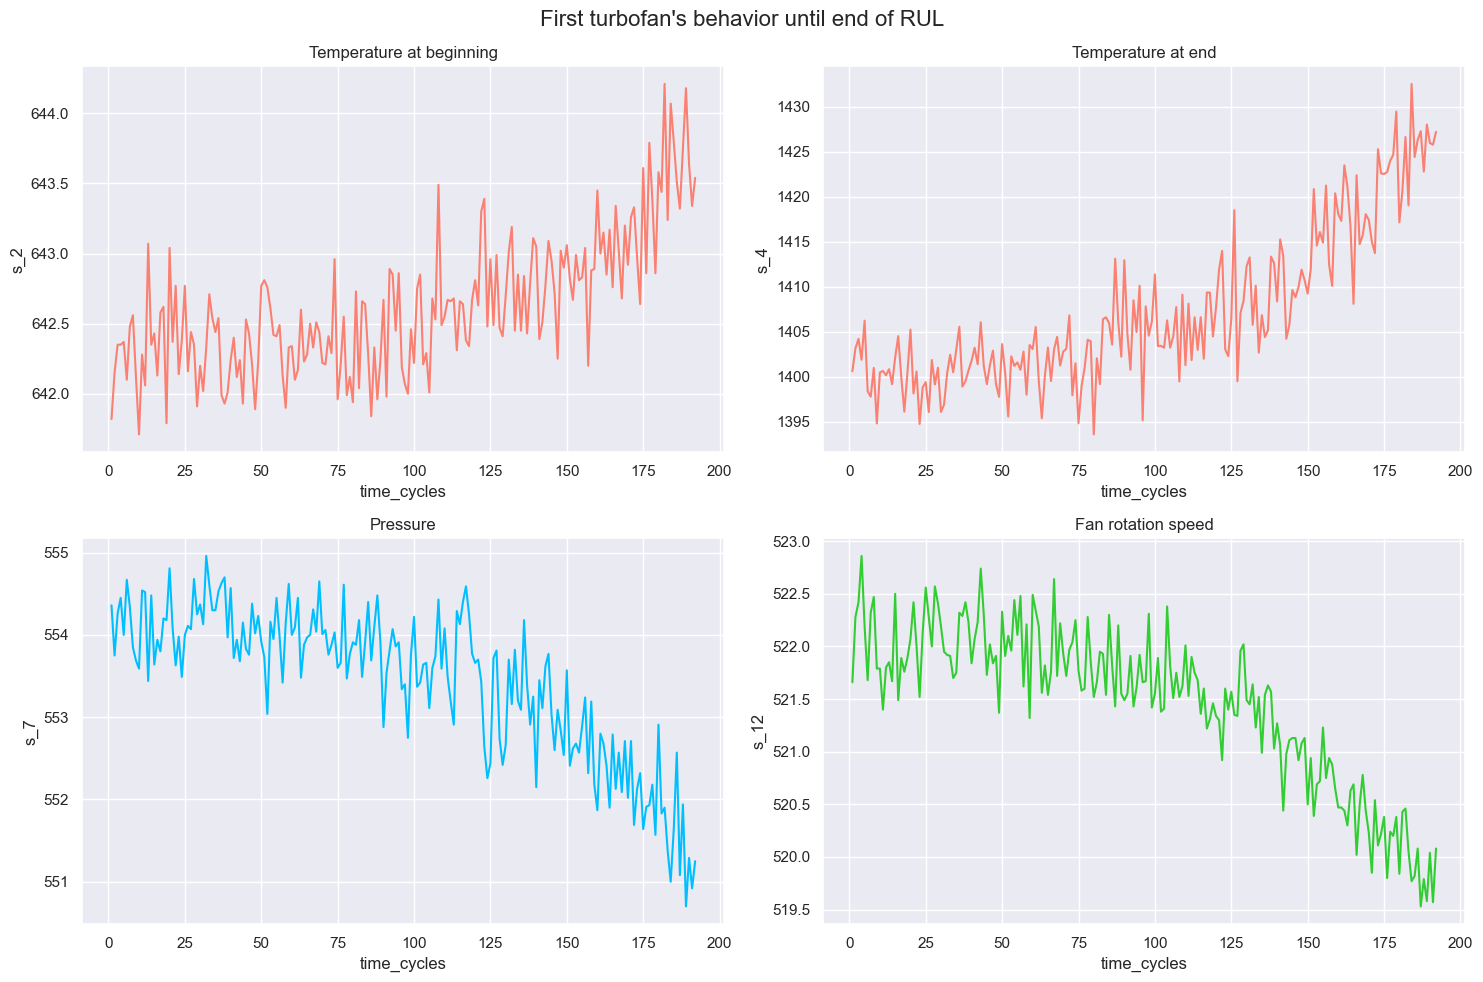

In [12]:
# creating a new dataframe containing only the first turbofan's data to plot it
turbofan_1 = df_train[df_train['unit_nr'] == 1]

# creating the figure that we will plot on
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('First turbofan\'s behavior until end of RUL', fontsize=16, family="Arial")

# initializing some variables we will need for our plot
sensors_to_plot = ["s_2", "s_4", "s_7", "s_12"]
subplot_titles = ["Temperature at beginning", "Temperature at end", "Pressure", "Fan rotation speed"]
subplot_colors = ["salmon","salmon","deepskyblue","limegreen"]
axes_to_plot = [[0,0],[0,1],[1,0],[1,1]]

# plotting with seaborn while using our newly made dataframe and our variables as parameters
for i in range(4):
    row, col = axes_to_plot[i]
    sns.lineplot(data=turbofan_1, x='time_cycles', y=sensors_to_plot[i], ax=axes[row, col], color=subplot_colors[i]).set(title=subplot_titles[i])

# setting the theme and using the layout function to avoid overlapping with our four plots and displaying the plot
sns.set_theme()
plt.tight_layout()
plt.savefig('img/first_turbofan_behavior.png')
plt.show()

Now we can try to deduce something from these plots, why do sensors react this way? 

* Rising temperatures (s_2, s_4): the extra fuel consumption creates more heat, causing temperatures (especially at the outlet, so s_4) to rise significantly as the engine approaches failure.

* Dropping pressures (s_7): degradation often involves gaps widening between blades and casing. This leads to air leakage and a loss of compression efficiency, causing pressure readings to drop.

* Dropping fan speed (s_12): as the engine blades wear down the fan experiences more "drag" (resistance) and struggles to maintain its optimal rotation speed.

### 4. Plot smoothing

As we can see, the sensors are prone to a lot of noise that make the plots unclear or harder to read, so I will now smooth these plots with a calculated rolling average to have a nicely shaped curve.

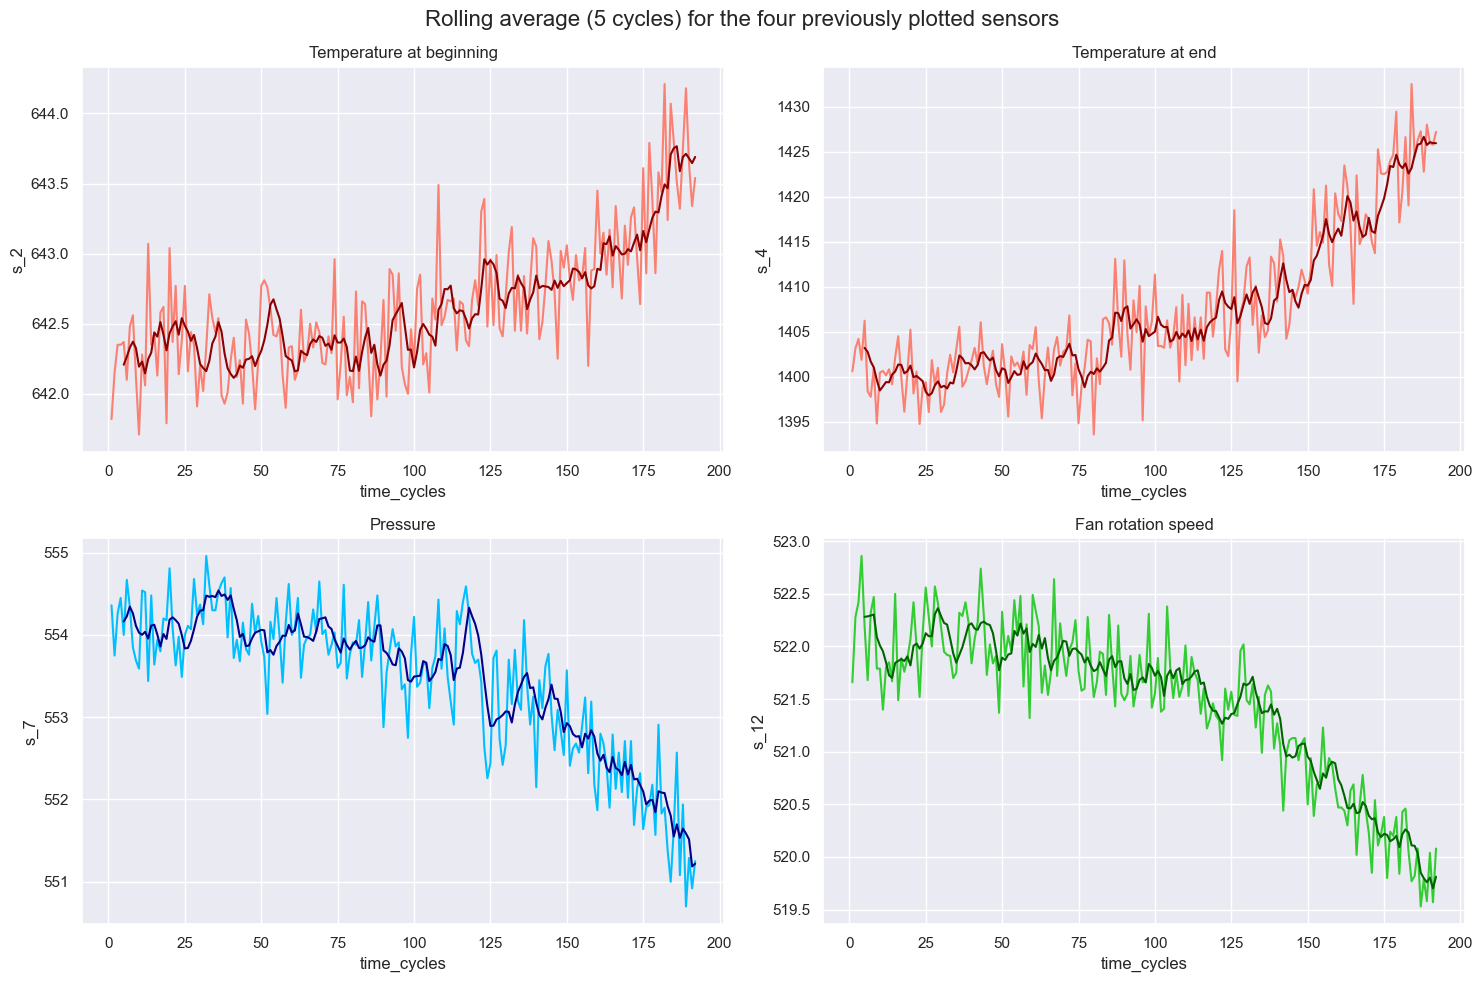

In [5]:
# creating a new dataframe containing only the first turbofan's data to smoothly plot it
df_train_smooth = df_train.copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Rolling average (5 cycles) for the four previously plotted sensors', fontsize=16, family="Arial")

sensors_to_smooth = ["s_2", "s_4", "s_7", "s_12"]
smooth_subplot_colors = ["darkred","darkred","darkblue","darkgreen"] 

# adding a new column to our newest dataframe to keep the rolling average so we can use the data
for i in sensors_to_smooth:
    df_train_smooth[i + '_smooth'] = df_train_smooth.groupby('unit_nr')[i].transform(lambda x: x.rolling(window=5).mean())

# only plotting for the first turbofan
plot_data = df_train_smooth[df_train_smooth['unit_nr'] == 1]

# plotting the previous data to compare it with our new smooth one
for i in range(4):
    row, col = axes_to_plot[i]
    sns.lineplot(data=plot_data, x='time_cycles', y=sensors_to_plot[i], ax=axes[row, col], color=subplot_colors[i], linewidth=1.5).set(title=subplot_titles[i])

# plotting again with the same parameters but this time using the "smooth" data
for i in range(4):
    row, col = axes_to_plot[i]
    sns.lineplot(data=plot_data, x='time_cycles', y=sensors_to_plot[i]+ '_smooth', ax=axes[row, col], color=smooth_subplot_colors[i], linewidth=1.5).set(title=subplot_titles[i])

plt.tight_layout()
plt.savefig('img/first_turbofan_smoothed.png')
plt.show()

### 5. Final preparations
The last step before we can use our dataframe to create, train and test a model, the model wont like the "NaN" cells (holes at the top of the dataframe made by the calculation of the rolling average) and will not work properly if it is given the smooth and raw data at the same time.

In [6]:
# creating our final dataframe, I will do that in a new copied dataframe so I still have access to the previous one for personnal reasons 
df_final = df_train_smooth.copy()

# ignoring the errors that happen when we execute this notebook cell more then one time without restarting
df_final.drop(('s_{}'.format(i) for i in range(1, 22)),axis='columns', inplace=True, errors='ignore') 

# removing the missing values
df_final.dropna(inplace=True)

# making sure that the missing values and the columns that were not needed anymore were removed properly
df_final.head()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20231 entries, 4 to 20630
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      20231 non-null  int64  
 1   time_cycles  20231 non-null  int64  
 2   setting_1    20231 non-null  float64
 3   setting_2    20231 non-null  float64
 4   setting_3    20231 non-null  float64
 5   RUL          20231 non-null  int64  
 6   s_2_smooth   20231 non-null  float64
 7   s_4_smooth   20231 non-null  float64
 8   s_7_smooth   20231 non-null  float64
 9   s_12_smooth  20231 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 1.7 MB


### 6. Machine learning
Now the interesting part, the machine learning, we will start with some preparations for our model, it will be divided in 80% for the training subset and 20% for the testing subset, the reason we are doing this and we are not training our model on the full train data and then testing it on the test data even though the NASA provides us with both is to properly evaluate our model and make sure our model is good enough before testing it with the real objective

In [7]:
# defining X (features)
# removing 'unit_nr' and 'time_cycles' to only keep the data sensors and keep the model from just learning which turbofan dies when
features_to_drop = ['unit_nr', 'time_cycles', 'RUL']
X = df_final.drop(columns=features_to_drop)

# defining y (target)
y = df_final['RUL']

# separating the data in 80/20 (0.2) like explained before
# using random_state=42 to keep our randomizer "seed" so we can ensure reproducibility of results 
# (this is needed to know that if the results are changing (in good or in bad) it is because of code modifications and not just luck)
# the number 42 was arbitrarily chosen and any other number would work too
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# making sure by checking that the data was divided properly
print(X_train.shape)
print(X_val.shape)

(16184, 7)
(4047, 7)


16 184 (80%) turbo fan cycles, 4047 (20%) hiddel cycles to calculate, 7 columns (parameters to calculate with)

### 7. Model training
Now that we have all the pieces needed, we can start training the model using the Random Forest algorithm and calculate our precision with an RMSE (Root Mean Squared Error).

Why Random Forest? It is like we are asking 100 different experts to estimate the remaining life of an engine based on their own ideas. Some might look closely at temperature, others at pressure. The Random Forest algorithm works the same way : it builds 100 small decision trees each looking at a random subset of data. To make the final prediction, it averages the answers from all 100 trees. This approach makes the model very robust against noise and errors.

Why RMSE? This metric tells us on average how many cycles our prediction is off by. For example, an RMSE of 20 means that our model's predictions are typically within more or less 20 cycles of the actual engine failure. I chose RMSE because it heavily penalizes large errors (thanks to the "squaring" part) which is critical in predictive maintenance where missing a failure by a large margin could be dangerous.

In [8]:
# using 100 trees for our random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# informing the user of the beginning of the training because it might take a few seconds
print("Model training started")

# fitting the model to the training data, so essentially training it 
rf_model.fit(X_train, y_train)

# testing our model with RUL numbers that were hidden to him during training (X_val)
y_pred = rf_model.predict(X_val)

# calculating rmse (y_pred) with reality (y_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# checking our RMSE (with 2 digits after the comma)
print(f"RMSE : {rmse:.2f} cycles")

Model training started
RMSE : 44.76 cycles


The RMSE was calculated to 44.76 which means that the rf_model model is, on average, 44.76 cycles away from the real answer. The turbofans in this dataset live between 150 and 300 cycles, meaning a 44 cycle error represents approximately 15% to 20% of the turbofan's entire life.

Is that data  useful?  
To predict the exact cycle at which the engine will stop working, no, the RMSE is too high making the prediction too vague.  
To give a "maintenance required" alert, yes, even with this margin of error we can see a difference between a new engine and an engine in its end on life.

Is the result good?  
The best deep learning models on this dataset (LSTM/CNN/...) are approximately at 15 to 20 RMSE.  
A basic Random Forest is generally at 40 to 50 RMSE.

### 8. Result visualization
Now we can use a plot to see the difference between the model predictions and reality, an easier way to understand the model's accuracy

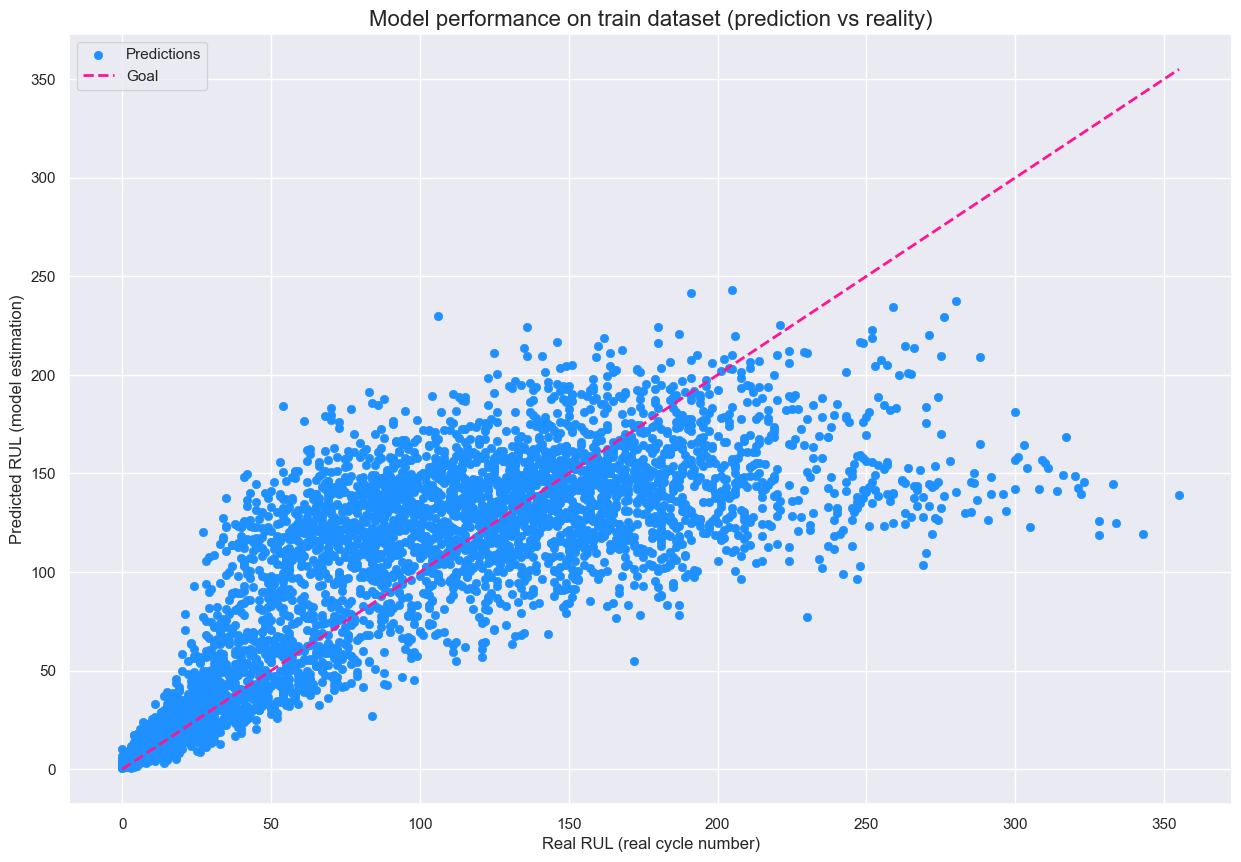

In [9]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=y_val, y=y_pred, color='dodgerblue', edgecolor='dodgerblue', label='Predictions')

# plotting the perfect guesses (diagonal)
sns.lineplot(x=[0, y_val.max()], y=[0, y_val.max()], color='deeppink', linestyle='--', linewidth=2, label='Goal')

plt.title('Model performance on train dataset (prediction vs reality)', fontsize=16)
plt.xlabel('Real RUL (real cycle number)')
plt.ylabel('Predicted RUL (model estimation)')
plt.savefig('img/model_ontrain.png')
plt.show()

Now let's analyze the plot.

At the bottom left (RUL < 80) : the predicted data is very close to the goal data. Meaning that when the turbofan is nearing its death the model is very precise which is when the prediction matters the most.  

At the middle right (RUL > 100) : The dots are flattening and going more to the right. Meaning that when the turbofan is still new, it is hard for the model to guess how many cycles it has left and to differentiate a 180 cycle turbo fan with a 130 cycle turbofan (since they are so similarly in "perfect" state.  

So we can now conclude with this first prediction on our training dataset that the model may not appear perfect but the "high" RSME number comes from the logical explanaition that it is has to make a guess for the model so early on.

### 9. Final test
Now that we have tested the model on our 80/20 training dataset we can now test it on the real exercise, the test dataset.

In [10]:
# doing mostly the same operations but on the test dataset this time
df_test_smooth = df_test.copy()

sensors_to_smooth = ["s_2", "s_4", "s_7", "s_12"]

for i in sensors_to_smooth:
    df_test_smooth[i + '_smooth'] = df_test_smooth.groupby('unit_nr')[i].transform( lambda x: x.rolling(window=5).mean() )

X_final_test = df_test_smooth.groupby('unit_nr').last().reset_index()

# removing the useless columns to keep the same ones as df_train
features_to_drop = ['unit_nr', 'time_cycles']

# df_test has no RUL so we don't need to remove it
X_final_test = X_final_test.drop(columns=features_to_drop + [f's_{i}' for i in range(1, 22)], errors='ignore')

# using the trained rf_model again
y_pred_test = rf_model.predict(X_final_test)

#  calculating the final RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Final RMSE on the real test set : {rmse_test:.2f} cycles")

Final RMSE on the real test set : 35.77 cycles


Now the RMSE is even lower with the real test, which is very good for our model.
We can now plot it to have a visual result like we have done in part 8.

KeyboardInterrupt: 

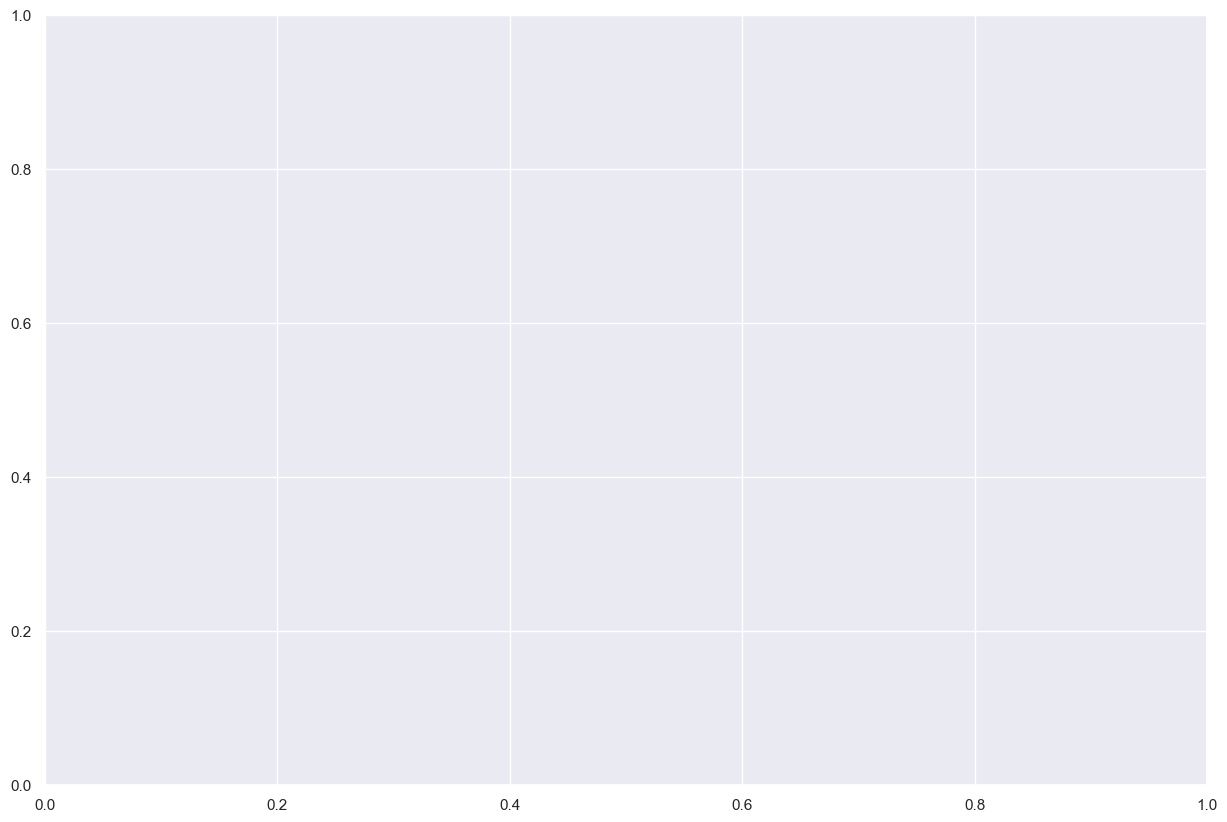

In [11]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=y_test['RUL'], y=y_pred_test, color='dodgerblue', edgecolor='dodgerblue', label='Predictions')

# checking the max value to stop the figure when there is no more needed data to see
max_val = y_test['RUL'].max()

# plotting the perfect guesses (diagonal)
sns.lineplot(x=[0, max_val], y=[0, max_val], color='deeppink', linestyle='--', linewidth=2, label='Goal')

plt.title('Model performance on test dataset (prediction vs reality)', fontsize=16)
plt.xlabel('Real RUL (real cycle number)')
plt.ylabel('Predicted RUL (model estimation)')
plt.savefig('img/model_ontest.png')
plt.show()

We can see that, as calculated, this time it is much more precise.

### 10. Saving the mode
Now that we have checked everything we needed to check and know that the model is working we can export it to re-use it in the future for this or another similar dataset.

In [ ]:
# saving the trained model
filename = 'rf_model_rul.pkl'
joblib.dump(rf_model, filename)
print(f"Model successfully saved under the filename : {filename}")